In [30]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.style.use('ggplot')

In [17]:
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"
img_size = (224, 224)
batch_size = 32

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # remaining 30% will be split into val+test
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Validation + Test dataset
temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_batches = int(0.5 * len(temp_ds))
val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

Found 4752 files belonging to 9 classes.
Using 3327 files for training.
Found 4752 files belonging to 9 classes.
Using 1425 files for validation.


In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

# Preprocessing for DenseNet (normalize to ImageNet stats)
preprocess_input = tf.keras.applications.densenet.preprocess_input

def prepare_train(ds):
    return ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

def prepare_val_test(ds):
    return ds.map(lambda x, y: (x, y),
                  num_parallel_calls=tf.data.AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = prepare_train(train_ds).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = prepare_val_test(val_ds).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = prepare_val_test(test_ds).cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# Load DenseNet Pretrained Model (with 'imagenet' weights)
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

base_model.trainable = False # Freeze early layers

In [20]:
# Build improved classification head
inputs = base_model.input

# Preprocessing layer
x = preprocess_input(inputs)

# Base model
x = base_model(x, training=False)  # Keep batch norm in inference mode initially

# Enhanced classification head
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(9, activation='softmax')(x)

# Define full model
dense_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
es=EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)
lr=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-8,
)

In [22]:
dense_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-4),
    metrics = ['accuracy'],
)

In [23]:
history = dense_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds,
    callbacks = [es, lr]
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 274ms/step - accuracy: 0.1908 - loss: 2.5593 - val_accuracy: 0.4815 - val_loss: 1.5522 - learning_rate: 1.0000e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.3893 - loss: 1.6920 - val_accuracy: 0.5795 - val_loss: 1.2559 - learning_rate: 1.0000e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.5214 - loss: 1.3775 - val_accuracy: 0.6250 - val_loss: 1.0905 - learning_rate: 1.0000e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.5617 - loss: 1.2333 - val_accuracy: 0.6605 - val_loss: 0.9973 - learning_rate: 1.0000e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6159 - loss: 1.0931 - val_accuracy: 0.6733 - val_loss: 0.9081 - learning_rate: 1.0000e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6491 - loss: 0.9973 - val_accuracy: 0.6875 - val_loss: 0.8530 - learning_rate: 1.0000e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/s

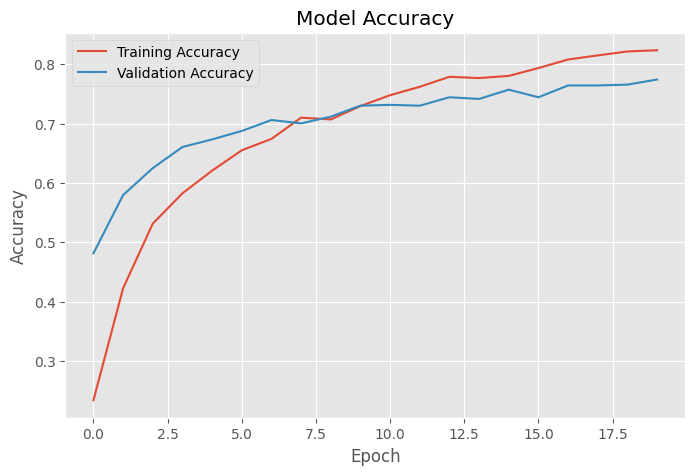

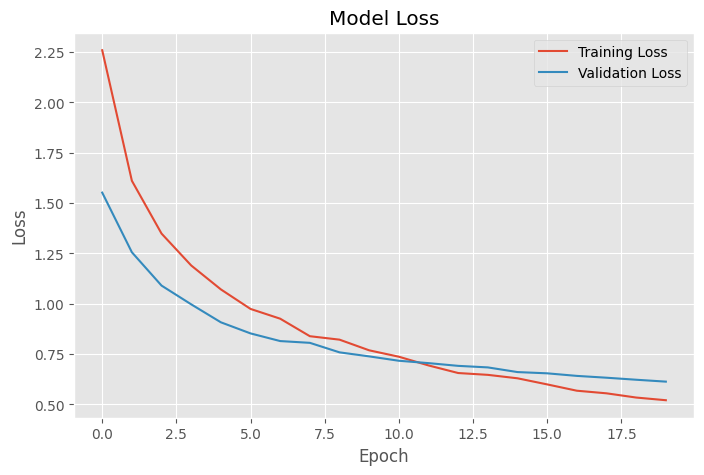

In [24]:
# Extract history
history = dense_model.history.history

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Best epoch (based on validation accuracy)
best_epoch = np.argmax(history['val_accuracy'])

best_train_acc = history['accuracy'][best_epoch]
best_val_acc = history['val_accuracy'][best_epoch]
best_train_loss = history['loss'][best_epoch]
best_val_loss = history['val_loss'][best_epoch]

print(f"Best Epoch: {best_epoch + 1}")
print(f"Training Accuracy: {best_train_acc * 100:.2f}%")
print(f"Validation Accuracy: {best_val_acc * 100:.2f}%")
print(f"Training Loss: {best_train_loss:.4f}")
print(f"Validation Loss: {best_val_loss:.4f}")

Best Epoch: 20
Training Accuracy: 82.36%
Validation Accuracy: 77.41%
Training Loss: 0.5211
Validation Loss: 0.6135


In [29]:
# Get class names
class_names = [d for d in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, d))]
print("Classes:", class_names)

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [31]:
# Gather true labels (works for batched tf.data)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Predictions (probabilities then class indices)
y_probs = dense_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_probs, axis=1)

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
                     precision    recall  f1-score   support

          Cardboard     0.7857    0.8462    0.8148        65
      Food Organics     0.7903    0.8167    0.8033        60
              Glass     0.8571    0.7059    0.7742        51
              Metal     0.8475    0.8264    0.8368       121
Miscellaneous Trash     0.7660    0.4800    0.5902        75
              Paper     0.8400    0.8289    0.8344        76
            Plastic     0.7627    0.8599    0.8084       157
      Textile Trash     0.8214    0.9200    0.8679        50
         Vegetation     0.8378    0.9394    0.8857        66

           accuracy                         0.8072       721
          macro avg     0.8121    0.8026    0.8017       721
       weighted avg     0.8074    0.8072    0.8021       721



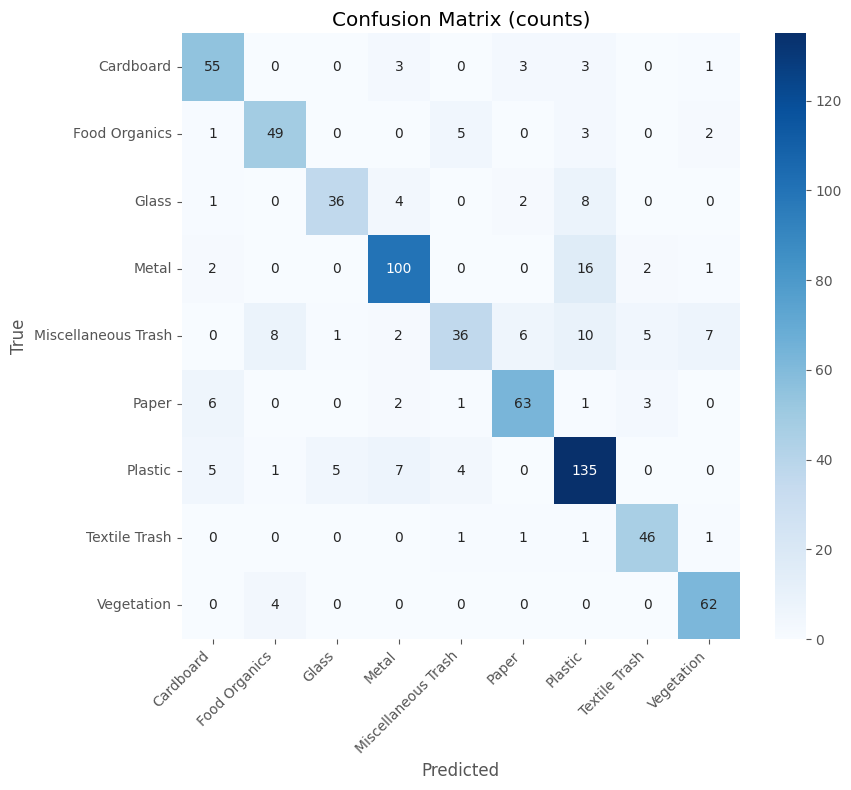

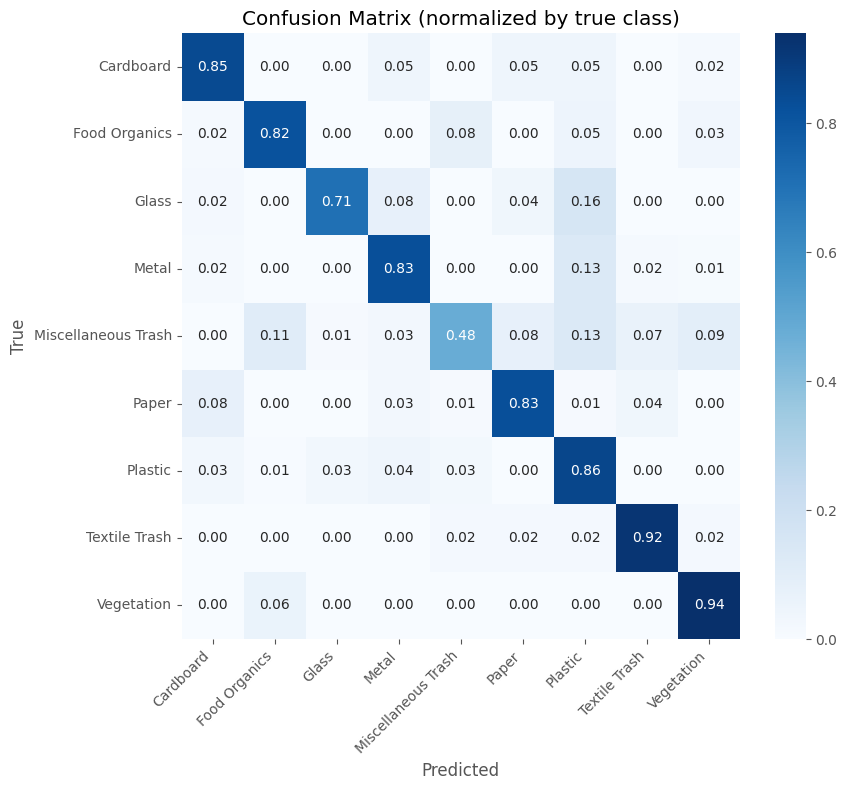

In [32]:
cm = confusion_matrix(y_true, y_pred)          # raw counts
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)  # per-row normalized (recall-wise)

# Plot raw confusion matrix
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (counts)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(9, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (normalized by true class)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()